# Version Control 0.01

Notes:
1) Currently, kd_0 and kd_100 give same results (Most likely interaction of gazebo physics, choosing highest kd which would be the foot kd in this case)
2) Different kp values change for all ranges (Checked only differences between kp=100e6 and kp=100e8)
3) Do I want to separate different ground parameter values??

# Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Read Simulation Data

## Read joint state data

In [3]:
filePath = "simData"
desiredStates = ['time','lf_hip_joint_position', 'lf_hip_joint_vel']

In [206]:
def preprocessSimData(df, desiredStates:list, initialIndex:int=300, finalIndex:int=812):
    '''
    Preprocess text file (fixing formatting issue in data as well) while returning a dataframe object with the desired states selected

    Parameters:
    -----------
    df: dataFrame
        Panda dataframe that is read from one of the recorded simulation .txt files
    desiredStates: list
        List of desired states to return as a panda dataframe object in sequential order

    Return:
    ----------
    stateMatrix: dataFrame
        State matrix with desired states
    '''



    # Fix formatting Variables
    falseList = ['time_lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort', 'nan']
    df.columns = falseList
    df['time_lf_hip_joint_position'] = df.time_lf_hip_joint_position.str[0:8] + ' ' + df.time_lf_hip_joint_position.str[8:]


    # Data and State Name List
    data = df.values # np array of data values
    namesList = ['time', 'lf_hip_joint_position', 'lf_lower_leg_joint_position', 'lf_upper_leg_joint_position', 'lh_hip_joint_position', 'lh_lower_leg_joint_position', 'lh_upper_leg_joint_position',
                'rf_hip_joint_position', 'rf_lower_leg_joint_position', 'rf_upper_leg_joint_position', 'rh_hip_joint_position', 'rh_lower_leg_joint_position', 'rh_upper_leg_joint_position',
                'lf_hip_joint_vel', 'lf_lower_leg_joint_vel', 'lf_upper_leg_joint_vel', 'lh_hip_joint_vel', 'lh_lower_leg_joint_vel', 'lh_upper_leg_joint_vel',
                'rf_hip_joint_vel', 'rf_lower_leg_joint_vel', 'rf_upper_leg_joint_vel', 'rh_hip_joint_vel', 'rh_lower_leg_joint_vel', 'rh_upper_leg_joint_vel',
                'lf_hip_joint_effort', 'lf_lower_leg_joint_effort', 'lf_upper_leg_joint_effort', 'lh_hip_joint_effort', 'lh_lower_leg_joint_effort', 'lh_upper_leg_joint_effort',
                'rf_hip_joint_effort', 'rf_lower_leg_joint_effort', 'rf_upper_leg_joint_effort', 'rh_hip_joint_effort', 'rh_lower_leg_joint_effort', 'rh_upper_leg_joint_effort']

    dictStates = {}
    staticCounter = 0 # Variable to account for formatting issue
    for index in range(len(namesList)-1):
        if index == 0 and staticCounter == 0: # Condition for formatting issue of collected data
            for j in range(len(data[:,index])): # Looping through all elements in column 0 and converting to float
                if j == 0: # Initialize array
                    array1 = float(data[j,index][0:8])
                    #print(array1)
                    array2 = float(data[j,index][8:])
                    #print(array2)
                else:
                    array1 = np.vstack((array1,float(data[j,index][0:8])))
                    array2 = np.vstack((array2,float(data[j,index][8:])))
            dictStates[namesList[index]] = np.squeeze(array1[initialIndex:finalIndex])
            dictStates[namesList[index+1]] = np.squeeze(array2[initialIndex:finalIndex])        
        else:
            dictStates[namesList[index+1]] = data[initialIndex:finalIndex,index]
    for counter, names in enumerate(desiredStates):
        if counter == 0:
            stateMatrix = np.reshape(dictStates[names], (-1,1))
        else:
            stateMatrix = np.hstack((stateMatrix, np.reshape(dictStates[names], (-1,1))))
    return pd.DataFrame(stateMatrix, columns = desiredStates)

# Read file(s)

In [207]:
def preprocessFile(fileNames:list, initialIndex:int, finalIndex:int, desiredStates:list):
    '''
    Given fileNames to read, reads the file(s) and returns all data concatenated in a panda dataframe framework

    Paramaters:
    -----------
    fileNames:list
        List of filenames to read and concatenate data together
    intialIndex: int
        Index to start reading each file's data from
    finalIndex: int
        Index to stop reading each file's data from
    desiredStates:list
        List of states to read
    
    Return:
    ----------
    totalData: dataFrame
        Returns data of all filenames with given states in one panda dataframe
    '''
    dataFrameList = []
    for i in fileNames:
        df = pd.read_csv(i, sep= " ", header=None)
        dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=initialIndex, finalIndex=finalIndex)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

    totalData = pd.concat(dataFrameList)
    return totalData

In [208]:
trajLength = 2**9
initialIndex, finalIndex= 300, 300+trajLength
desiredStates = ['time','lf_hip_joint_position', 'lf_hip_joint_vel']
fileNames = glob.glob(filePath+"/plane_kp_100e10_kd_500/joint_state_test_plane_kp_100e10_kd_500_right_0.7*")
dataframe = preprocessFile(fileNames,initialIndex,finalIndex, desiredStates)

512


# Plot individual graphs

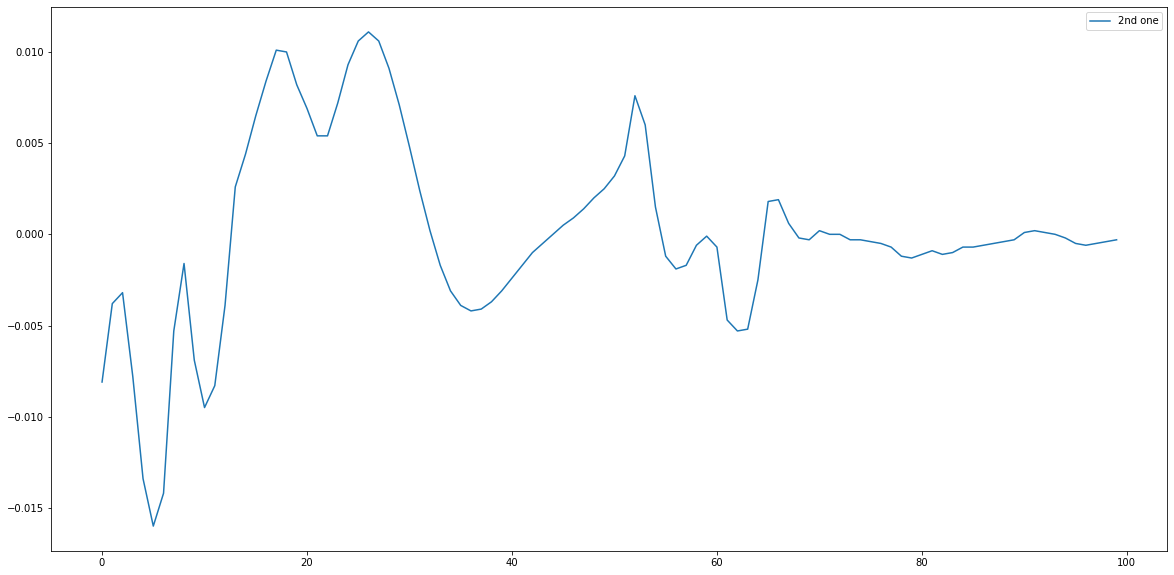

In [210]:
desiredStates = ['time','lf_hip_joint_position', 'lf_hip_joint_vel']
fileNames = glob.glob(filePath+"/plane_kp_100e6_kd_100/joint_state*")
dataFrameList = []

trajLength = 2**9
initialIndex, finalIndex= 300, 300+trajLength



for i in fileNames:
    df = pd.read_csv(i, sep= " ", header=None)
    dataFrameList.append(preprocessSimData(df, desiredStates, initialIndex=200, finalIndex=initialIndex+trajLength-1)) # 712-200 = 512 --> 512-1 is 512 indices (i.e. [0, 511])

totalData2 = pd.concat(dataFrameList)


plt.figure(figsize=(20,10))
plt.plot(totalData2.values[0:100,1], label="2nd one")
plt.legend()